# Pre-process ERA5 pressure level data for CREDIT

This notebook provides methods on gathering ERA5 pressure level data from NCAR/RDA and ARCO-ERA5. The RDA data requires internal access of the glade file system at NCAR.

## Data preparation

* 0.25 degree single-level variables were pre-processed from pressure level data. This notebook prepares upper-air variables on model level

**References**

* NCAR/RDA
    * [ERA5 Reanalysis (0.25 Degree Latitude-Longitude Grid)](https://rda.ucar.edu/datasets/d633000/)
    * glade storage: `/glade/campaign/collections/rda/data/d633000/`
* ARCO-ERA5
    * [Google Cloud storage](https://console.cloud.google.com/storage/browser/gcp-public-data-arco-era5)
    * [Project page at GitHub](https://github.com/google-research/arco-era5)
    * Complete hourly file: `gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3`



In [1]:
import os
import sys
import yaml
import dask
import zarr
import numpy as np
import xarray as xr
import pandas as pd
from glob import glob
from dask.utils import SerializableLock

import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu
import interp_utils as iu

In [2]:
# import multiprocessing
# from dask.distributed import Client
# from dask_jobqueue import PBSCluster

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def create_hourly_datetime_strings(year):
    # Generate hourly date range for the entire year
    date_range = pd.date_range(start=f'{year}-01-01T00', end=f'{year}-12-31T23', freq='H')
    # Format each datetime to the desired string format
    datetime_strings = date_range.strftime('%Y-%m-%dT%H').tolist()
    
    return datetime_strings

## Model level coefs

In [86]:
values_col1 = [
    0, 2.000365, 3.102241, 4.666084, 6.827977, 9.746966, 13.605424, 18.608931, 24.985718, 
    32.98571, 42.879242, 54.955463, 69.520576, 86.895882, 107.415741, 131.425507, 
    159.279404, 191.338562, 227.968948, 269.539581, 316.420746, 368.982361, 427.592499, 
    492.616028, 564.413452, 643.339905, 729.744141, 823.967834, 926.34491, 1037.201172, 
    1156.853638, 1285.610352, 1423.770142, 1571.622925, 1729.448975, 1897.519287, 
    2076.095947, 2265.431641, 2465.770508, 2677.348145, 2900.391357, 3135.119385, 
    3381.743652, 3640.468262, 3911.490479, 4194.930664, 4490.817383, 4799.149414, 
    5119.89502, 5452.990723, 5798.344727, 6156.074219, 6526.946777, 6911.870605, 
    7311.869141, 7727.412109, 8159.354004, 8608.525391, 9076.400391, 9562.682617, 
    10065.97852, 10584.63184, 11116.66211, 11660.06738, 12211.54785, 12766.87305, 
    13324.66895, 13881.33106, 14432.13965, 14975.61523, 15508.25684, 16026.11523, 
    16527.32227, 17008.78906, 17467.61328, 17901.62109, 18308.43359, 18685.71875, 
    19031.28906, 19343.51172, 19620.04297, 19859.39063, 20059.93164, 20219.66406, 
    20337.86328, 20412.30859, 20442.07813, 20425.71875, 20361.81641, 20249.51172, 
    20087.08594, 19874.02539, 19608.57227, 19290.22656, 18917.46094, 18489.70703, 
    18006.92578, 17471.83984, 16888.6875, 16262.04688, 15596.69531, 14898.45313, 
    14173.32422, 13427.76953, 12668.25781, 11901.33984, 11133.30469, 10370.17578, 
    9617.515625, 8880.453125, 8163.375, 7470.34375, 6804.421875, 6168.53125, 
    5564.382813, 4993.796875, 4457.375, 3955.960938, 3489.234375, 3057.265625, 
    2659.140625, 2294.242188, 1961.5, 1659.476563, 1387.546875, 1143.25, 
    926.507813, 734.992188, 568.0625, 424.414063, 302.476563, 202.484375, 
    122.101563, 62.78125, 22.835938, 3.757813, 0, 0
]
values_col2 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0.000007, 0.000024, 0.000059, 0.000112, 0.000199, 
    0.00034, 0.000562, 0.00089, 0.001353, 0.001992, 0.002857, 0.003971, 
    0.005378, 0.007133, 0.009261, 0.011806, 0.014816, 0.018318, 0.022355, 
    0.026964, 0.032176, 0.038026, 0.044548, 0.051773, 0.059728, 0.068448, 
    0.077958, 0.088286, 0.099462, 0.111505, 0.124448, 0.138313, 0.153125, 
    0.16891, 0.185689, 0.203491, 0.222333, 0.242244, 0.263242, 0.285354, 
    0.308598, 0.332939, 0.358254, 0.384363, 0.411125, 0.438391, 0.466003, 
    0.4938, 0.521619, 0.549301, 0.576692, 0.603648, 0.630036, 0.655736, 
    0.680643, 0.704669, 0.727739, 0.749797, 0.770798, 0.790717, 0.809536, 
    0.827256, 0.843881, 0.859432, 0.873929, 0.887408, 0.8999, 0.911448, 
    0.922096, 0.931881, 0.94086, 0.949064, 0.95655, 0.963352, 0.969513, 
    0.975078, 0.980072, 0.984542, 0.9885, 0.991984, 0.995003, 0.99763, 1
]

# Convert to two 1D numpy arrays
coef_a = np.array(values_col1)
coef_b = np.array(values_col2)

In [87]:
# p_half = coef_a + coef_b*101325
# p_level = 0.5*(p_half[1:] + p_half[:-1])/100

In [100]:
config_name = os.path.realpath('data_config_mlevel_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

# save to zarr
base_dir = conf['zarr_opt']['save_loc_1deg'] + 'static/'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

In [111]:
levels = np.arange(1, 139).astype(np.float32)
# Create the xarray.Dataset with `coef_a` and `coef_b` as variables
ds = xr.Dataset({
    'coef_a': (['half_level'], coef_a),
    'coef_b': (['half_level'], coef_b)
}, coords={'half_level': levels})

In [112]:
fn_static = '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/static/ERA5_plevel_1deg_6h_conserve_static.zarr'
ds_static_plevel = xr.open_zarr(fn_static)

# Drop the 'level' dimension, coordinate, and any variables associated with it from `ds_static_plevel`
ds_static_plevel = ds_static_plevel.drop_dims('level', errors='ignore').drop_vars('level', errors='ignore')

# Drop all variables that include the 'level' dimension
ds_static_plevel = ds_static_plevel.drop_vars(
    [var for var in ds_static_plevel if 'level' in ds_static_plevel[var].dims])

In [113]:
ds_static_mlevel = xr.merge([ds_static_plevel, ds])

In [115]:
# ================================================================================== #
# chunk
varnames = list(ds_static_mlevel.keys())
varnames = varnames[:-2] # subtract coef a b

for i_var, var in enumerate(varnames):
    ds_static_mlevel[var] = ds_static_mlevel[var].chunk({'latitude': 181, 'longitude': 360})

# zarr encodings
dict_encoding = {}

chunk_size_2d = dict(chunks=(conf['zarr_opt']['chunk_size_3d_1deg']['latitude'],
                             conf['zarr_opt']['chunk_size_3d_1deg']['longitude']))

compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)

for i_var, var in enumerate(varnames):
    dict_encoding[var] = {'compressor': compress, **chunk_size_2d}

In [116]:
save_name = base_dir + 'ERA5_mlevel_1deg_6h_conserve_static.zarr'
# ds_static_mlevel.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)

## Upper-air variables

**ARCO**

* Hourly data from `gs://gcp-public-data-arco-era5/ar/model-level-1h-0p25deg.zarr-v1/`

In [4]:
year = 1979
N_days = 366 if year % 4 == 0 else 365

config_name = os.path.realpath('data_config_mlevel_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

# save to zarr
base_dir = conf['zarr_opt']['save_loc_1deg'] + 'upper_air/source/' 
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

variables_levels = {}
for varname in conf['ARCO']['varname_upper_air']:
    variables_levels[varname] = None

In [14]:
ERA5_1h = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/model-level-1h-0p25deg.zarr-v1/",
    chunks=None,
    consolidated=True,
    storage_options=dict(token='anon'),)

hourly_datetimes = create_hourly_datetime_strings(year)
N_time_gap = 3 #len(hourly_datetimes)//6

for i in range(N_time_gap):
    time_pick = hourly_datetimes[6*i]

    save_name = base_dir + 'ERA5_mlevel_1deg_{}_conserve.nc'.format(time_pick)
    try:
        ds_test = xr.open_dataset(save_name)
        ds_test.close()
        print('{} Exist'.format(save_name))
    except:
        ERA5_6h = ERA5_1h.sel(time=time_pick)
    

        
        ERA5_6h_save = vu.ds_subset_everything(ERA5_6h, variables_levels)
        ERA5_6h_save = ERA5_6h_save.rename({'hybrid': 'level',})
        ds_merge = ERA5_6h_save
        
        # ======================================================================================= #
        # 0.25 deg to 1 deg interpolation using conservative approach
        if i == 0:
            # Define the target 1-degree grid
            lon_1deg = np.arange(0, 360, 1)
            lat_1deg = np.arange(-90, 91, 1)
            target_grid = iu.Grid.from_degrees(lon_1deg, lat_1deg)
            
            lon_025deg = ds_merge['longitude'].values
            lat_025deg = ds_merge['latitude'].values[::-1]
            source_grid = iu.Grid.from_degrees(lon_025deg, lat_025deg)
            
            regridder = iu.ConservativeRegridder(source=source_grid, target=target_grid)
        
        ds_merge = ds_merge.chunk({'longitude': -1, 'latitude': -1})
        ds_merge_1deg = regridder.regrid_dataset(ds_merge)
        
        # Reorder the dimensions for all variables in ds_merge_1deg
        for var in ds_merge_1deg.data_vars:
            # Get the current dimensions of the variable
            current_dims = ds_merge_1deg[var].dims
            
            # If both 'latitude' and 'longitude' are present, reorder them
            if 'latitude' in current_dims and 'longitude' in current_dims:
                # New order: move 'latitude' and 'longitude' to the first two positions, preserve other dimensions
                new_order = [dim for dim in current_dims if dim not in ['latitude', 'longitude']] + ['latitude', 'longitude']
                
                # Transpose the variable to the new order
                ds_merge_1deg[var] = ds_merge_1deg[var].transpose(*new_order)
        
        lon_1deg = np.arange(0, 360, 1)
        lat_1deg = np.arange(-90, 91, 1)
        
        # Add latitude and longitude as coordinates to ds_merge_1deg
        ds_merge_1deg = ds_merge_1deg.assign_coords({
            'latitude': lat_1deg,
            'longitude': lon_1deg
        })
        
        # flip latitude from -90 --> 90 to 90 --> -90
        ds_merge_1deg = ds_merge_1deg.isel(latitude=slice(None, None, -1))
        
        # float64 --> float32
        ds_merge_1deg = ds_merge_1deg.astype(
            {var: np.float32 for var in ds_merge_1deg if ds_merge_1deg[var].dtype == np.float64})
    
        # Convert latitude, longitude, and level coordinates to float32
        ds_merge_1deg = ds_merge_1deg.assign_coords({
            'latitude': ds_merge_1deg['latitude'].astype(np.float32),
            'longitude': ds_merge_1deg['longitude'].astype(np.float32),
            'level': ds_merge_1deg['level'].astype(np.float32)
        })
        
        # ds_merge_1deg.to_netcdf(save_name, mode='w', compute=True)
        print('Save to {}'.format(save_name))

/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/upper_air/source/ERA5_mlevel_1deg_1979-01-01T00_conserve.nc Exist
/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/upper_air/source/ERA5_mlevel_1deg_1979-01-01T06_conserve.nc Exist
Save to /glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/upper_air/source/ERA5_mlevel_1deg_1979-01-01T12_conserve.nc


### Check quality

In [8]:
ERA5_1h = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/model-level-1h-0p25deg.zarr-v1/",
    chunks=None,
    consolidated=True,
    storage_options=dict(token='anon'),)

hourly_datetimes = create_hourly_datetime_strings(year)
N_time_gap = 3 #len(hourly_datetimes)//6

i = 0
time_pick = hourly_datetimes[6*i]
save_name = base_dir + 'ERA5_mlevel_1deg_{}_conserve.nc'.format(time_pick)
ds_test = xr.open_dataset(save_name)

In [9]:
# ERA5_6h = ERA5_1h.sel(time=time_pick)
# ERA5_6h_save = vu.ds_subset_everything(ERA5_6h, variables_levels)
# ERA5_6h_save = ERA5_6h_save.rename({'hybrid': 'level',})
# ds_merge = ERA5_6h_save

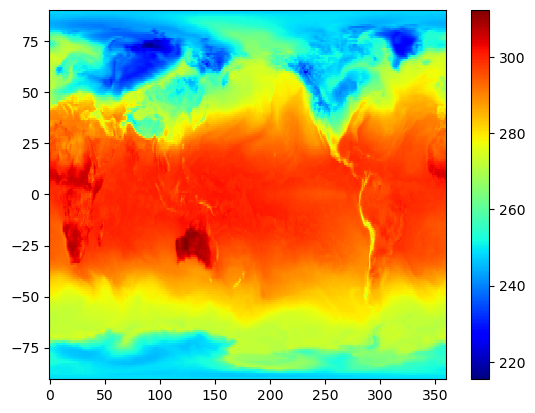

In [25]:
T = ds_test['temperature'].isel(level=136).values

lon = ds_test['longitude'].values
lat = ds_test['latitude'].values

plt.pcolormesh(lon, lat, T, cmap=plt.cm.jet)
plt.colorbar()

### Combine single nc files

In [50]:
year = 1979
N_days = 366 if year % 4 == 0 else 365

config_name = os.path.realpath('data_config_mlevel_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [51]:
# save to zarr
source_dir = conf['zarr_opt']['save_loc_1deg'] + 'upper_air/source/' 
base_dir = conf['zarr_opt']['save_loc_1deg'] + 'upper_air/' 
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

In [ ]:
hourly_datetimes = create_hourly_datetime_strings(year)
N_time_gap = len(hourly_datetimes)//6

file_collection = []

for i in range(N_time_gap):
    time_pick = hourly_datetimes[6*i]
    
    save_name = source_dir + 'ERA5_mlevel_1deg_{}_conserve.nc'.format(time_pick)
    
    file_collection.append(xr.open_dataset(save_name))

ds_merge_1deg = xr.concat(file_collection, dim='time')

# ========================================================================== #
# chunking

varnames = list(ds_merge_1deg.keys())

for i_var, var in enumerate(varnames):
    ds_merge_1deg[var] = ds_merge_1deg[var].chunk(conf['zarr_opt']['chunk_size_4d_1deg'])

# zarr encodings
dict_encoding = {}

chunk_size_4d = dict(chunks=(conf['zarr_opt']['chunk_size_4d_1deg']['time'],
                             conf['zarr_opt']['chunk_size_4d_1deg']['level'],
                             conf['zarr_opt']['chunk_size_4d_1deg']['latitude'],
                             conf['zarr_opt']['chunk_size_4d_1deg']['longitude']))

compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)

for i_var, var in enumerate(varnames):
    dict_encoding[var] = {'compressor': compress, **chunk_size_4d}

save_name = base_dir + 'ERA5_mlevel_1deg_6h_{}_conserve.zarr'.format(year)
# ds_merge_1deg.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)

## Cloud & humidity variables

In [5]:
year = 1979
N_days = 366 if year % 4 == 0 else 365

config_name = os.path.realpath('data_config_mlevel_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

# save to zarr
base_dir = conf['zarr_opt']['save_loc_1deg'] + 'cloud/source/' 
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

variables_levels = {}
varnames = ['specific_cloud_ice_water_content', 
            'specific_cloud_liquid_water_content',
            'specific_rain_water_content', 
            'specific_snow_water_content']

for varname in varnames:
    variables_levels[varname] = None

In [49]:
ERA5_1h = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/model-level-1h-0p25deg.zarr-v1/",
    chunks=None,
    consolidated=True,
    storage_options=dict(token='anon'),)

hourly_datetimes = create_hourly_datetime_strings(year)
N_time_gap = 3 #len(hourly_datetimes)//6

for i in range(N_time_gap):
    time_pick = hourly_datetimes[6*i]

    save_name = base_dir + 'ERA5_mlevel_1deg_cloud_{}_conserve.nc'.format(time_pick)
    try:
        ds_test = xr.open_dataset(save_name)
        ds_test.close()
        print('{} Exist'.format(save_name))
    except:
        ERA5_6h = ERA5_1h.sel(time=time_pick)
        ERA5_6h_save = vu.ds_subset_everything(ERA5_6h, variables_levels)
        ERA5_6h_save = ERA5_6h_save.rename({'hybrid': 'level',})
        ds_merge = ERA5_6h_save
        
        # ======================================================================================= #
        # 0.25 deg to 1 deg interpolation using conservative approach
        if i == 0:
            # Define the target 1-degree grid
            lon_1deg = np.arange(0, 360, 1)
            lat_1deg = np.arange(-90, 91, 1)
            target_grid = iu.Grid.from_degrees(lon_1deg, lat_1deg)
            
            lon_025deg = ds_merge['longitude'].values
            lat_025deg = ds_merge['latitude'].values[::-1]
            source_grid = iu.Grid.from_degrees(lon_025deg, lat_025deg)
            
            regridder = iu.ConservativeRegridder(source=source_grid, target=target_grid)
        
        ds_merge = ds_merge.chunk({'longitude': -1, 'latitude': -1})
        ds_merge_1deg = regridder.regrid_dataset(ds_merge)
        
        # Reorder the dimensions for all variables in ds_merge_1deg
        for var in ds_merge_1deg.data_vars:
            # Get the current dimensions of the variable
            current_dims = ds_merge_1deg[var].dims
            
            # If both 'latitude' and 'longitude' are present, reorder them
            if 'latitude' in current_dims and 'longitude' in current_dims:
                # New order: move 'latitude' and 'longitude' to the first two positions, preserve other dimensions
                new_order = [dim for dim in current_dims if dim not in ['latitude', 'longitude']] + ['latitude', 'longitude']
                
                # Transpose the variable to the new order
                ds_merge_1deg[var] = ds_merge_1deg[var].transpose(*new_order)
        
        lon_1deg = np.arange(0, 360, 1)
        lat_1deg = np.arange(-90, 91, 1)
        
        # Add latitude and longitude as coordinates to ds_merge_1deg
        ds_merge_1deg = ds_merge_1deg.assign_coords({
            'latitude': lat_1deg,
            'longitude': lon_1deg
        })
        
        # flip latitude from -90 --> 90 to 90 --> -90
        ds_merge_1deg = ds_merge_1deg.isel(latitude=slice(None, None, -1))
        
        # float64 --> float32
        ds_merge_1deg = ds_merge_1deg.astype(
            {var: np.float32 for var in ds_merge_1deg if ds_merge_1deg[var].dtype == np.float64})
    
        # Convert latitude, longitude, and level coordinates to float32
        ds_merge_1deg = ds_merge_1deg.assign_coords({
            'latitude': ds_merge_1deg['latitude'].astype(np.float32),
            'longitude': ds_merge_1deg['longitude'].astype(np.float32),
            'level': ds_merge_1deg['level'].astype(np.float32)
        })
        
        ds_merge_1deg.to_netcdf(save_name, mode='w', compute=True)
        print('Save to {}'.format(save_name))

/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/cloud/source/ERA5_mlevel_1deg_cloud_1979-01-01T00_conserve.nc Exist
/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/cloud/source/ERA5_mlevel_1deg_cloud_1979-01-01T06_conserve.nc Exist
/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/cloud/source/ERA5_mlevel_1deg_cloud_1979-01-01T12_conserve.nc Exist


### Check quality

In [7]:
hourly_datetimes = create_hourly_datetime_strings(year)
i = 4
time_pick = hourly_datetimes[6*i]
save_name = base_dir + 'ERA5_mlevel_1deg_cloud_{}_conserve.nc'.format(time_pick)
ds_test = xr.open_dataset(save_name)

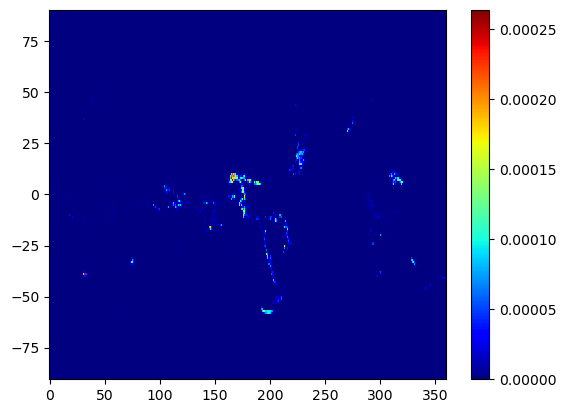

In [11]:
T = ds_test['specific_cloud_liquid_water_content'].isel(level=90).values

lon = ds_test['longitude'].values
lat = ds_test['latitude'].values

plt.pcolormesh(lon, lat, T, cmap=plt.cm.jet)
plt.colorbar()

In [15]:
# ERA5_1h = xr.open_zarr(
#     "gs://gcp-public-data-arco-era5/ar/model-level-1h-0p25deg.zarr-v1/",
#     chunks=None,
#     consolidated=True,
#     storage_options=dict(token='anon'),)

# ERA5_6h = ERA5_1h.sel(time=time_pick)
# ERA5_6h_save = vu.ds_subset_everything(ERA5_6h, variables_levels)
# ERA5_6h_save = ERA5_6h_save.rename({'hybrid': 'level',})
# ds_merge = ERA5_6h_save

In [16]:
# T = ds_merge['specific_cloud_liquid_water_content'].isel(level=90).values

# lon = ds_merge['longitude'].values
# lat = ds_merge['latitude'].values

# plt.pcolormesh(lon, lat, T, cmap=plt.cm.jet)
# plt.colorbar()

### Combine single nc files

In [43]:
year = 2007
N_days = 366 if year % 4 == 0 else 365

config_name = os.path.realpath('data_config_mlevel_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [44]:
# save to zarr
source_dir = conf['zarr_opt']['save_loc_1deg'] + 'cloud/source/' 
base_dir = conf['zarr_opt']['save_loc_1deg'] + 'cloud/' 
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

In [45]:
hourly_datetimes = create_hourly_datetime_strings(year)
N_time_gap = len(hourly_datetimes)//6

file_collection = []

for i in range(N_time_gap):
    time_pick = hourly_datetimes[6*i]
    
    save_name = source_dir + 'ERA5_mlevel_1deg_cloud_{}_conserve.nc'.format(time_pick)
    
    file_collection.append(xr.open_dataset(save_name))

ds_merge_1deg = xr.concat(file_collection, dim='time')

# ========================================================================== #
# chunking

varnames = list(ds_merge_1deg.keys())

for i_var, var in enumerate(varnames):
    ds_merge_1deg[var] = ds_merge_1deg[var].chunk(conf['zarr_opt']['chunk_size_4d_1deg'])

# zarr encodings
dict_encoding = {}

chunk_size_4d = dict(chunks=(conf['zarr_opt']['chunk_size_4d_1deg']['time'],
                             conf['zarr_opt']['chunk_size_4d_1deg']['level'],
                             conf['zarr_opt']['chunk_size_4d_1deg']['latitude'],
                             conf['zarr_opt']['chunk_size_4d_1deg']['longitude']))

compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)

for i_var, var in enumerate(varnames):
    dict_encoding[var] = {'compressor': compress, **chunk_size_4d}

save_name = base_dir + 'ERA5_mlevel_1deg_6h_cloud_{}_conserve.zarr'.format(year)
# ds_merge_1deg.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)

In [21]:
# ds_merge_1deg.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)

## Final quality checks

**Coordinate value NaNs**

In [ ]:
# debug NaN
# for i, ds in enumerate(file_collection):
#     if ds['longitude'].to_index().duplicated().any():
#         print("NaN found in longitude")
#         print(i)

**Consistency between plevel and mlevel files**

In [8]:
def check_dimension_consistency(ds_plevel, ds_mlevel, ds_cloud, dim):
    """Check if the specified dimension is consistent across three datasets."""
    return (ds_plevel[dim] == ds_mlevel[dim]).all() and (ds_mlevel[dim] == ds_cloud[dim]).all()

In [9]:
base_dir_plevel = '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/'
base_dir_mlevel = '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/'

for year in np.arange(1979, 2024):

    filename_ERA5 = base_dir_plevel + f'all_in_one/ERA5_plevel_1deg_6h_{year}_conserve.zarr'
    ds_plevel = xr.open_zarr(filename_ERA5)
    
    filename_ERA5 = base_dir_mlevel + f'upper_air/ERA5_mlevel_1deg_6h_{year}_conserve.zarr'
    ds_mlevel = xr.open_zarr(filename_ERA5)
    
    filename_cloud = base_dir_mlevel + f'cloud/ERA5_mlevel_1deg_6h_cloud_{year}_conserve.zarr'
    ds_cloud = xr.open_zarr(filename_cloud)
    
    # Check each dimension for consistency
    flag_time = check_dimension_consistency(ds_plevel, ds_mlevel, ds_cloud, 'time')
    flag_lon = check_dimension_consistency(ds_plevel, ds_mlevel, ds_cloud, 'longitude')
    flag_lat = check_dimension_consistency(ds_plevel, ds_mlevel, ds_cloud, 'latitude')
    
    # Validate all flags and print appropriate message
    if flag_time and flag_lon and flag_lat:
        print(f'Year {year} pass')
    else:
        # Raise informative errors based on the failed flag
        if not flag_time:
            raise ValueError("Time dimensions are not consistent across datasets.")
        if not flag_lon:
            raise ValueError("Longitude dimensions are not consistent across datasets.")
        if not flag_lat:
            raise ValueError("Latitude dimensions are not consistent across datasets.")

Year 1979 pass
Year 1980 pass
Year 1981 pass
Year 1982 pass
Year 1983 pass
Year 1984 pass
Year 1985 pass
Year 1986 pass
Year 1987 pass
Year 1988 pass
Year 1989 pass
Year 1990 pass
Year 1991 pass
Year 1992 pass
Year 1993 pass
Year 1994 pass
Year 1995 pass
Year 1996 pass
Year 1997 pass
Year 1998 pass
Year 1999 pass
Year 2000 pass
Year 2001 pass
Year 2002 pass
Year 2003 pass
Year 2004 pass
Year 2005 pass
Year 2006 pass
Year 2007 pass
Year 2008 pass
Year 2009 pass
Year 2010 pass
Year 2011 pass
Year 2012 pass
Year 2013 pass
Year 2014 pass
Year 2015 pass
Year 2016 pass
Year 2017 pass
Year 2018 pass
Year 2019 pass
Year 2020 pass
Year 2021 pass
Year 2022 pass
Year 2023 pass
